# Transfomer 모델들을 사용해 에너지 예측 (BDG2)

참고
> https://github.com/buds-lab/building-data-genome-project-2
- BUDS Lab(University of Toronto)에서 주관한 공공 건물 에너지 사용량 예측 대회 및 연구 데이터셋
- 1,636개 건물에서 수집된 2년치(2016-2017) 시계열 에너지 데이터로 구성
- chilled water, gas, electricity, hotwater, irrigation, solar, steam, water 데이터 존재

## Import libraries

In [1]:
# Import libraries and modules
import torch

from utils.setup_dataset import setup_dataset
from utils.preprocess_data import load_and_preprocess
from plots.plot import plot_data_by_month
from plots.plot import plot_forecast

from models.Transformer import TimeSeriesTransformer
from models.Informer import Informer
from models.Autoformer import Autoformer
from models.FEDformer import FEDformer
from models.PatchTST import PatchTST

from utils.train import train_model
from utils.metrics import mae, rmse, mape
from utils.test import test_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Preprocess data

In [2]:
year = 2017
building_name = "Panther_parking_Lorriane"
filepath = f"C:/Users/ryudo/OneDrive - gachon.ac.kr/AiCE2/석사논문/Transformer/BDG2/data/toronto_data_{year}.csv"
input_window = 168  # 입력 윈도우 크기
output_window = 24  # 출력 윈도우 크기

# 1. 데이터 불러오기
# setup_dataset.py
raw_data = setup_dataset(year, building_name)

# 2. 데이터 전처리
# preprocess_data.py
X_train, y_train, X_val, y_val, X_test, y_test, X_scaler, y_scaler = load_and_preprocess(filepath, input_window, output_window)

[저장 완료 | Building: Panther_parking_Lorriane, Year: 2017]: C:/Users/ryudo/OneDrive - gachon.ac.kr/AiCE2/석사논문/Transformer/BDG2/data/toronto_data_2017_Panther_parking_Lorriane.csv
Train X: torch.Size([6817, 168, 4]) y: torch.Size([6817, 24, 1])
Valid  X: torch.Size([685, 168, 4]) y: torch.Size([685, 24, 1])
Test  X: torch.Size([685, 168, 4]) y: torch.Size([685, 24, 1])


## Data Visualization

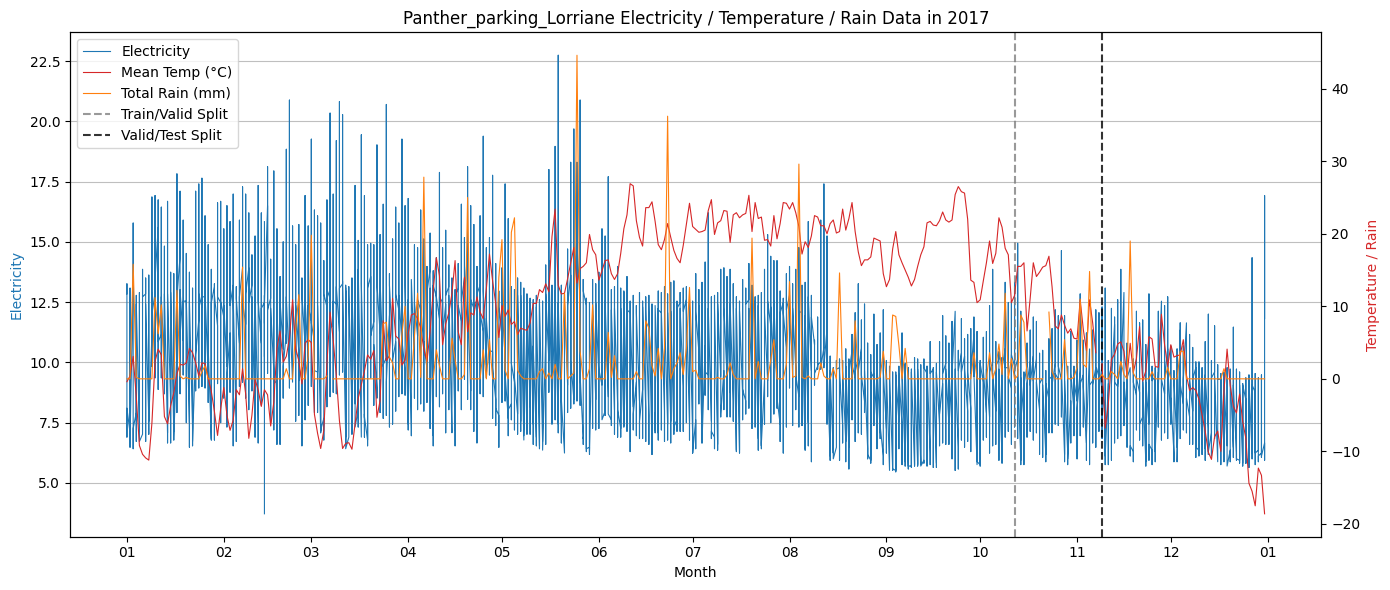

[저장 완료] plots/png/Panther_parking_Lorriane_2017_data_plot.png


In [3]:
# 3. 데이터 시각화
# plot.py
plot_data_by_month(filepath, building_name, year, X_train, X_val)

## Model Initialization

### Transformer

In [28]:
# 하이퍼파라미터
d_model = 64
nhead = 4
num_layers = 3
dim_feedforward = 128
input_dim = X_train.shape[-1] 
dropout = 0.1
output_dim = 1  
pool="last"  

In [29]:
# Transformer 초기화
Transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    pool=pool
).to(device)

print(Transformer)

TimeSeriesTransformer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=4, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding()
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (enc_norm): LayerN

### Informer

In [30]:
max_len=500
head_hidden=256
use_decoder=False
d_layers=1  

# Informer 초기화
Informer = Informer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    max_len=max_len,
    pool=pool,
    head_hidden=head_hidden,
    use_decoder=use_decoder,
    d_layers=d_layers
).to(device)

print(Informer)

Informer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=4, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding()
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): EncoderLayer(
      (self_attn): ProbSparseSelfAttention(
        (q_proj): Linear(in_features=64, out_features=64, bias=True)
        (k_proj): Linear(in_features=64, out_features=64, bias=True)
        (v_proj): Linear(in_features=64, out_features=64, bias=True)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): ReLU()
        (2): 

### Autoformer

In [31]:
input_len=168 # 과거 창 길이 (168, 336, 720 ...)
pred_len=24 # 예측 창 길이 (24, 48, 96 ...)
enc_layers = 2
dec_layers = 1
moving_avg = 25

# Autoformer 초기화
Autoformer = Autoformer(
    input_len=input_len,
    pred_len=pred_len, 
    d_model=d_model, 
    moving_avg=moving_avg,
    enc_layers=enc_layers, 
    dec_layers=dec_layers, 
    dropout=dropout, 
    input_dim=input_dim
).to(device)

print(Autoformer)

Autoformer(
  (enc_embedding): Linear(in_features=4, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (decomp1): SeriesDecomposition(
          (moving_avg): MovingAverage()
        )
        (auto_corr): AutoCorrelation()
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
        )
        (decomp2): SeriesDecomposition(
          (moving_avg): MovingAverage()
        )
        (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
       

### FEDformer

In [32]:
mode_select_num=16
kernel_size=25

# FEDformer 초기화
FEDformer = FEDformer(
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    mode_select_num=mode_select_num,
    kernel_size=kernel_size,
    dropout=dropout,
    pool=pool
).to(device)

print(FEDformer)

FEDformer(
  (input_proj): Linear(in_features=4, out_features=64, bias=True)
  (decomp): SeriesDecomposition(
    (moving_avg): MovingAverage()
  )
  (fourier): FourierBlock()
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.1, inplace=False)
  (decoder): Linear(in_features=64, out_features=24, bias=True)
)


### PatchTST

In [33]:
patch_size = 24  # 패치 크기 (예: 24시간 단위로 패치)

# PatchTST 초기화
PatchTST = PatchTST(
    input_window=input_window,
    patch_size=patch_size,
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    num_layers=num_layers,
    nhead=nhead,
    dropout=dropout
).to(device)

print(PatchTST)

PatchTST(
  (embedding): PatchEmbedding(
    (proj): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (emb_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (emb_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, o

## Training the models

In [ ]:
# 모델 리스트 
model_list = [
    Transformer,
    Informer,
    Autoformer,
    FEDformer,
    PatchTST
]
batch_size = 32
lr = 1e-3  # 학습률
weight_decay = 1e-4  # 가중치 감쇠
num_epochs = 50

# 모델 학습 및 validation
for model in model_list:
    print(f"Training {model.__class__.__name__}...")
    train_model(
        model=model,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        num_epochs=num_epochs
    )
    print(f"----------{model.__class__.__name__} training complete.----------\n")

Training TimeSeriesTransformer...


c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 001 | Train MAE: 0.0297 | Val MAE: 0.0121 (best 0.0121)
[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 002 | Train MAE: 0.0100 | Val MAE: 0.0121 (best 0.0121)
Epoch 003 | Train MAE: 0.0094 | Val MAE: 0.0122 (best 0.0121)
Epoch 004 | Train MAE: 0.0088 | Val MAE: 0.0125 (best 0.0121)
Epoch 005 | Train MAE: 0.0086 | Val MAE: 0.0139 (best 0.0121)
----------TimeSeriesTransformer training complete.----------

Training Informer...
[최적 Informer모델 저장 완료] results/Informer-BDG2.pt
Epoch 001 | Train MAE: 0.0394 | Val MAE: 0.0122 (best 0.0122)
Epoch 002 | Train MAE: 0.0113 | Val MAE: 0.0131 (best 0.0122)
[최적 Informer모델 저장 완료] results/Informer-BDG2.pt
Epoch 003 | Train MAE: 0.0090 | Val MAE: 0.0120 (best 0.0120)
[최적 Informer모델 저장 완료] results/Informer-BDG2.pt
Epoch 004 | Train MAE: 0.0083 | Val MAE: 0.0118 (best 0.0118)
[최적 Informer모델 저장 완료] results/Informer-BDG2.pt
Epoch 005 | Train MAE: 0.

## Test & Evaluate

In [35]:
results = {}

for model in model_list:
    name = model.__class__.__name__
    print(f"Evaluating {name}...")

    preds, trues = test_model(
        model=model,
        X_test=X_test,
        y_test=y_test,
        X_scaler=X_scaler,
        y_scaler=y_scaler
    )

    # 평가 지표 계산 
    mae_value  = mae(preds, trues)
    rmse_value = rmse(preds, trues)
    mape_value = mape(preds, trues)

    # 결과 저장
    results[name] = {
        "preds": preds,
        "trues": trues,
        "mae": mae_value,
        "rmse": rmse_value,
        "mape": mape_value,
    }

    # 출력
    try:
        print(f"[{model.__class__.__name__} 모델 성능] MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}, MAPE: {mape_value:.2f}%\n")
    except Exception:
        # 포맷 불가 시 일반 출력
        print(f"{name} - MAE: {mae_value}, RMSE: {rmse_value}, MAPE: {mape_value}\n")

Evaluating TimeSeriesTransformer...
[TimeSeriesTransformer 모델 성능] MAE: 2.5757, RMSE: 2.8159, MAPE: 24.06%

Evaluating Informer...
[Informer 모델 성능] MAE: 2.2913, RMSE: 2.7495, MAPE: 19.78%

Evaluating Autoformer...
[Autoformer 모델 성능] MAE: 2.2731, RMSE: 2.8024, MAPE: 19.81%

Evaluating FEDformer...
[FEDformer 모델 성능] MAE: 2.5129, RMSE: 3.1860, MAPE: 21.35%

Evaluating PatchTST...
[PatchTST 모델 성능] MAE: 1.5175, RMSE: 1.8075, MAPE: 13.40%



## Plot Result

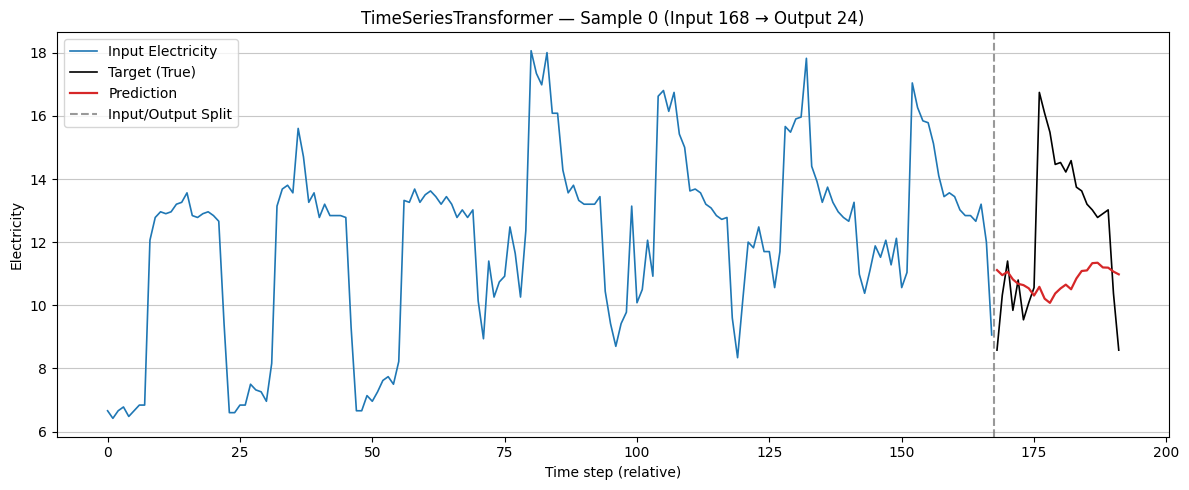

[TimeSeriesTransformer 모델 결과 저장 완료] plots/png/TimeSeriesTransformer_sample_0_forecast.png


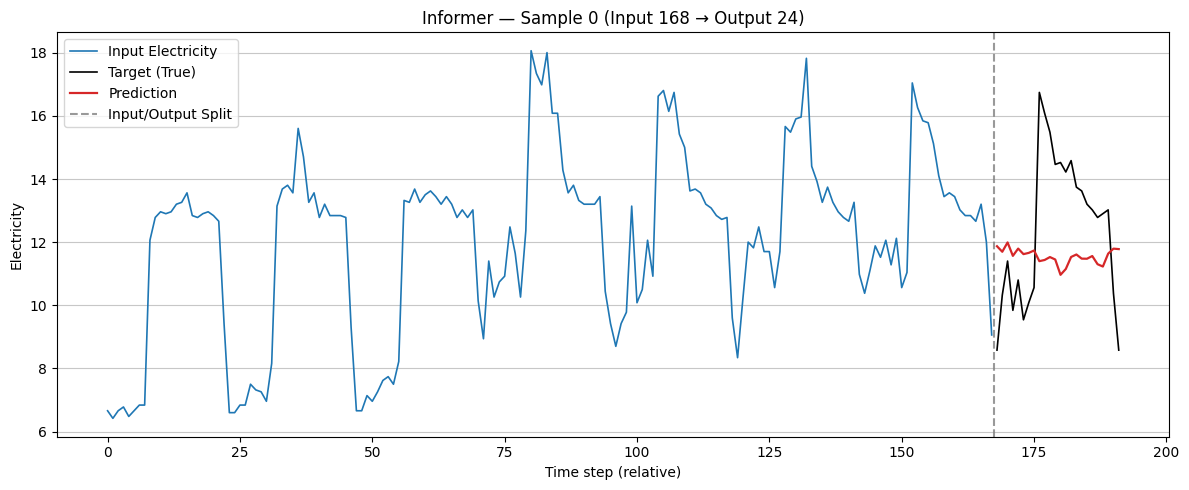

[Informer 모델 결과 저장 완료] plots/png/Informer_sample_0_forecast.png


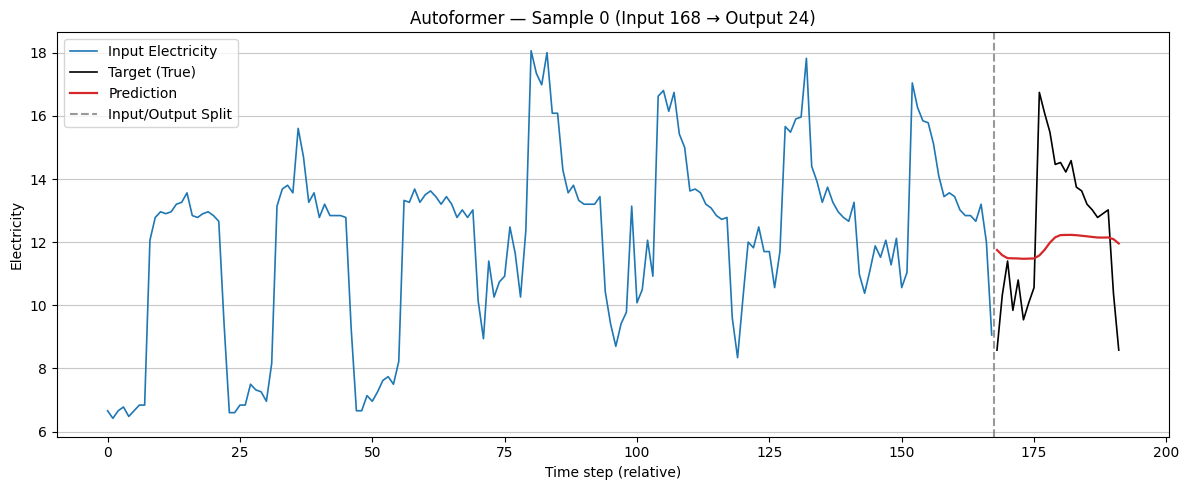

[Autoformer 모델 결과 저장 완료] plots/png/Autoformer_sample_0_forecast.png


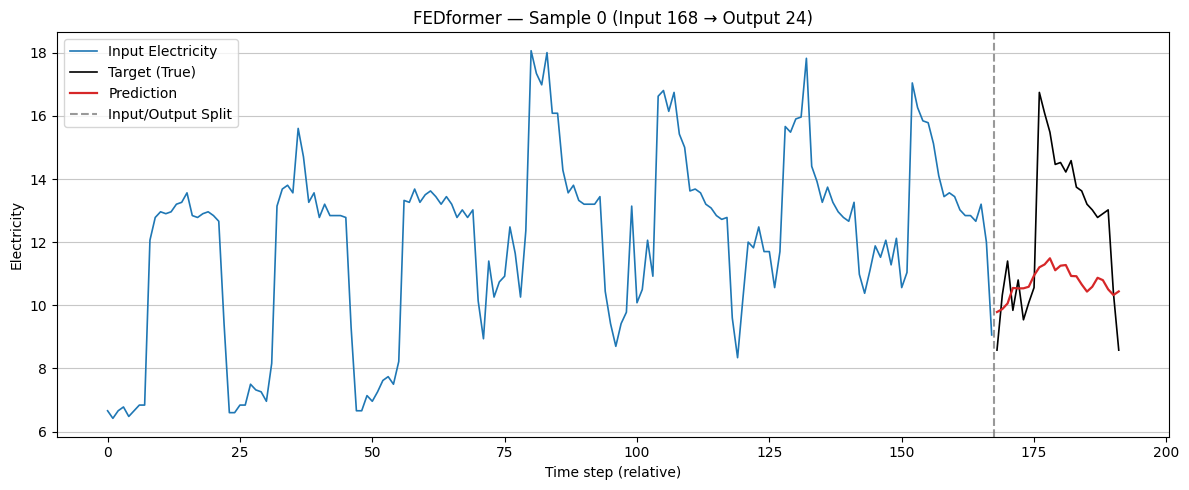

[FEDformer 모델 결과 저장 완료] plots/png/FEDformer_sample_0_forecast.png


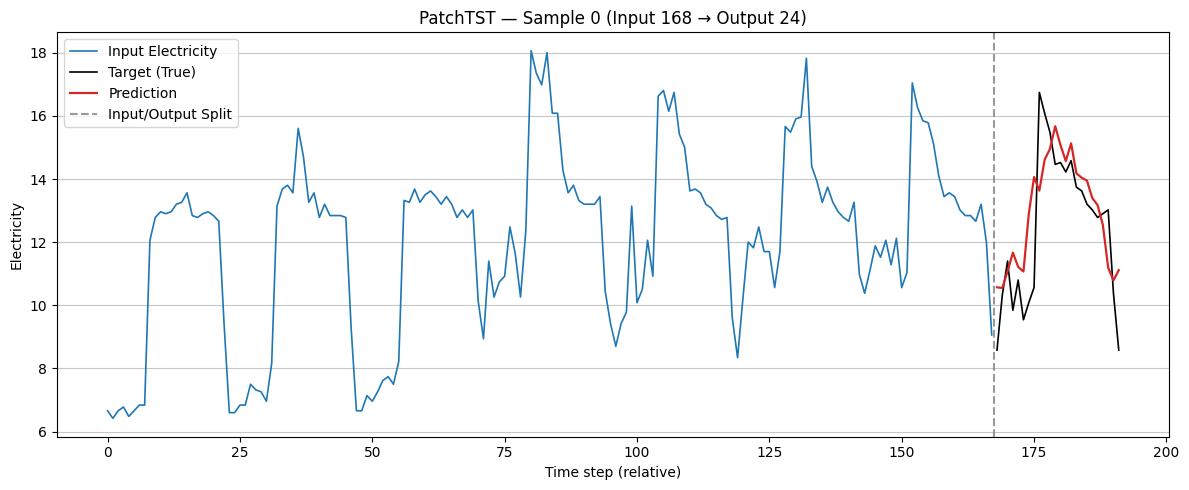

[PatchTST 모델 결과 저장 완료] plots/png/PatchTST_sample_0_forecast.png


In [36]:
sample_index = 0  # 시각화할 샘플 인덱스

for model in model_list:
    name = model.__class__.__name__                                # 모델 클래스명 문자열 추출

    preds = results[name]["preds"]                                 # 해당 모델의 예측값 가져오기
    trues = results[name]["trues"]                                 # 해당 모델의 실제값 가져오기

    # 시각화
    plot_forecast(
        model=model,
        preds=preds,
        trues=trues,
        input_window=input_window,
        output_window=output_window,
        sample_index=sample_index,
        X_test=X_test,
        x_scaler=X_scaler
    )

## END